#  Data Preparation

<b>Data Source</b><br>
We collected our data using the official data from Federal Reserve Economic Data(FRED) https://fred.stlouisfed.org. The <b>time period</b> of this dataset is 10 years monthly data from April 2013 to March 2023.  <br><br>
<b>Data Cleaning</b><br>Our data cleaning process contains the following procedure: <br> <b>    1.</b> Calculate the percentage return of S&P 500 data using the formula: (Current Period - Last Period)*100/Last Period<br>
<b>    2.</b> Scynchronize the data to the same frequency and merge data.<br>
<b>    3.</b> Check for NULL values and use linear trend to fill them.<br>
<b>    4.</b> Calculate other needed data (lags and leads data)<br>

In [70]:
import pandas_datareader as pdr
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
## get uneployment rate and sp500 return data
start_date = '2013-04-15'
un_data = pdr.data.DataReader('UNRATE', 'fred', start_date)
T = len(un_data)
index = pd.date_range(start = '2013-04',periods = T,freq = 'M')
un_data.index = index 

sp_data = pdr.data.DataReader('SP500','fred', start_date)
sp_data =sp_data.resample('M').mean()
sp_data['return_rate'] =(sp_data['SP500']/sp_data['SP500'].shift(1)-1)*100

## merge data
ori_data = pd.merge(sp_data, un_data, left_index = True, right_index =True)

In [3]:
ori_data.isnull().sum()

SP500          0
return_rate    1
UNRATE         0
dtype: int64

In [4]:
ori_data.interpolate(method='linear', inplace=True)

In [5]:
## 1 period lead for S&P 500
ori_data['ld1_sp'] = ori_data['SP500'].shift(-1)
## 2 periods lead for S&P 500
ori_data['ld2_sp'] = ori_data['SP500'].shift(-2)
## 3 periods lead for S&P 500
ori_data['ld3_sp'] = ori_data['SP500'].shift(-3)

## 1 period lag for unemployment rate
ori_data['lag1_un'] = ori_data['UNRATE'].shift(1)
## 1 period lag for S&P 500
ori_data['lag1_sp'] = ori_data['SP500'].shift(1)

In [6]:
ori_data.interpolate(method='linear', inplace=True)

In [7]:
## finish data cleaning. Name ori_data --> data
data = ori_data
data = data.drop(index = '2013-04-30')

In [8]:
data.isnull().sum()

SP500          0
return_rate    0
UNRATE         0
ld1_sp         0
ld2_sp         0
ld3_sp         0
lag1_un        0
lag1_sp        0
dtype: int64

# I. Data Introduction

Unemployment rate is always considered as a lagging indicator for economics. A bullish market might predict low unemployment rate. In order to find the relationship between unemployment rate and stock price, we introduce the following dataset contains <b>unemployment</b> rate, <b>S&P 500</b> index value and its growth rate. The <b>time period</b> of this dataset is 10 years monthly data from April 2013 to March 2023. 

In [9]:
data.head()

,SP500,return_rate,UNRATE,ld1_sp,ld2_sp,ld3_sp,lag1_un,lag1_sp
2013-05-31,1639.842727,3.612797,7.5,1618.772500,1668.675455,1670.093636,7.5,1582.664286
2013-06-30,1618.772500,-1.284893,7.3,1668.675455,1670.093636,1687.173500,7.5,1639.842727
2013-07-31,1668.675455,3.082765,7.2,1670.093636,1687.173500,1720.026522,7.3,1618.772500
2013-08-31,1670.093636,0.084988,7.2,1687.173500,1720.026522,1783.541000,7.2,1668.675455
2013-09-30,1687.173500,1.022689,7.2,1720.026522,1783.541000,1807.775238,7.2,1670.093636


In [10]:
data.describe()

,SP500,return_rate,UNRATE,ld1_sp,ld2_sp,ld3_sp,lag1_un,lag1_sp
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,2804.610163,0.863823,5.123729,2825.286791,2846.141979,2866.574261,5.157627,2783.448973
std,866.362833,3.350379,1.822306,867.440866,867.768493,868.191609,1.829035,865.447318
min,1618.772500,-19.068070,3.400000,1618.772500,1668.675455,1670.093636,3.400000,1582.664286
25%,2076.649042,-0.311072,3.800000,2080.146966,2081.011322,2082.619683,3.800000,2068.047024
50%,2658.982869,1.332977,4.750000,2682.917068,2702.133723,2703.964536,4.800000,2653.009437
75%,3385.161667,2.748817,5.875000,3411.953523,3516.419716,3658.730625,5.900000,3343.688214
max,4674.772727,6.338024,14.700000,4674.772727,4674.772727,4674.772727,14.700000,4674.772727


## 1. Scatter Plot

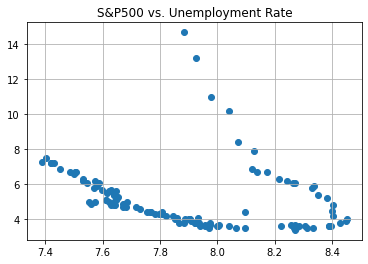

In [11]:
plt.title('S&P500 vs. Unemployment Rate')
plt.scatter(np.log(data['SP500']), data['UNRATE'])
plt.grid()

## 2. Outliers 

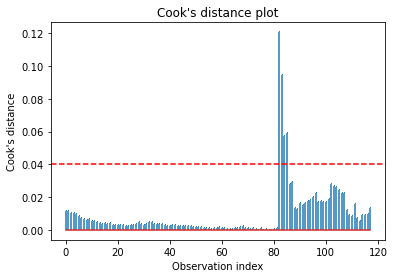

In [12]:
X = np.log(data['UNRATE'])
y = data['SP500']
model = smf.ols('y ~ X', data = data).fit()

# Calculate Cook's distance
influence = model.get_influence()
cook_dist = influence.cooks_distance[0]

# Plot Cook's distance
plt.stem(cook_dist, markerfmt=",")

# Add a horizontal line at the threshold value
plt.axhline(y=0.04, color="r", linestyle="--")

plt.title("Cook's distance plot")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.show()



# III. Results 
## 1. Modeling and Forecasting Trend
### (a) Time-seires plot

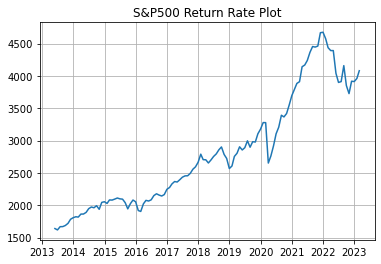

In [13]:
plt.title('S&P500 Return Rate Plot')
plt.plot(data['SP500'])
plt.grid()

### (b) Stationary

In [14]:
from statsmodels.tsa.stattools import adfuller
values = data['SP500'].values

# Run the ADF test
result = adfuller(values)
result[1]

0.8848454613732237

<b>Illustration:</b> According to ADF test, the dataset is stationary.

### (c) ACF and PACF

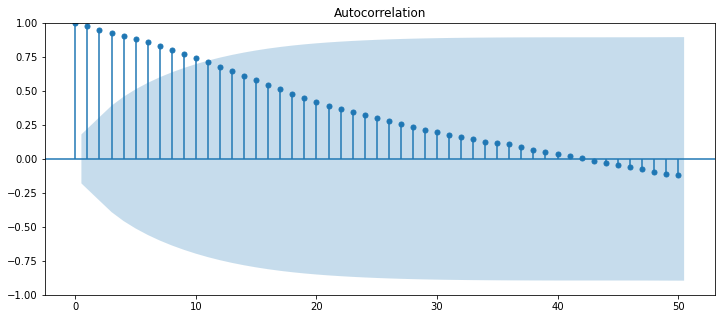

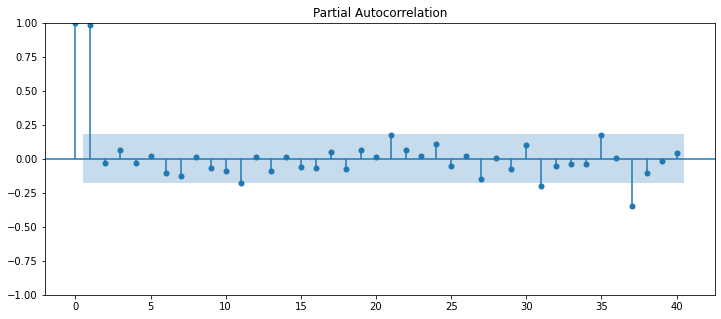

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot the ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data['SP500'], lags=50, ax=ax)
plt.show()

# Plot the PACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(data['SP500'], lags=40, ax=ax)
plt.show()

<b> Illustration</b>
1. There are many autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
2. High degree of autocorrelation between adjacent (lag = 14,32) in PACF plot
3. Seasonality and cycle can be spotted in the plots

### (d) Fitted Model 
#### (1) Linear Model

In [16]:
li_fit = smf.ols('SP500 ~ UNRATE', data = data).fit()
print(li_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     8.046
Date:                Sun, 23 Apr 2023   Prob (F-statistic):            0.00538
Time:                        15:43:14   Log-Likelihood:                -961.16
No. Observations:                 118   AIC:                             1926.
Df Residuals:                     116   BIC:                             1932.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3425.0152    232.023     14.762      0.0

<b>Comment: </b><br> 1. R-squared(4.9%) suggest the model is a poor fit. <br>2. The p-value for F-statistic in this model is 0.015, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well.

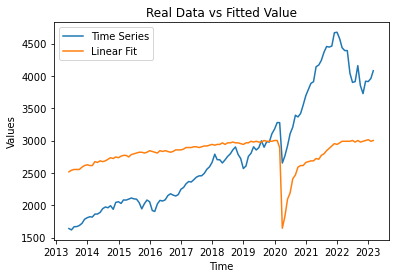

In [38]:
y_fit = li_fit.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['SP500'], label='Time Series')
ax.plot(data.index, y_fit, label='Linear Fit')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Real Data vs Fitted Value')
plt.show()

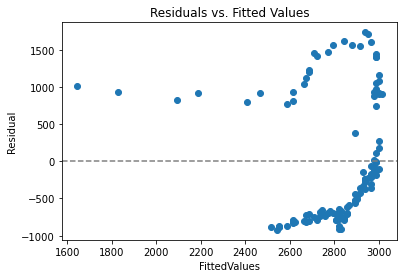

In [18]:
y_residual = li_fit.resid

fig, ax = plt.subplots()
ax.scatter(y_fit, y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

<b>Comment: </b>There is a cone shaped pattern in the residuals by fitted value plot, suggesting heteroskedaticity. 

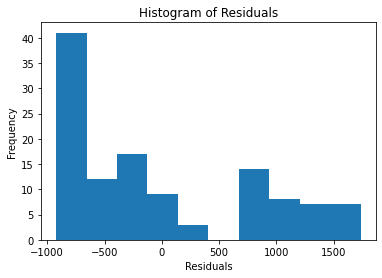

In [19]:
plt.hist(y_residual, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

<b>Comment: </b>The residual histogram shows that most residuals are smaller than zero. This means the fitted values are often smaller than actual values. There is also a decay in residuals' frequency. 

#### (2) Quadratic Model

In [20]:
qu_fit = smf.ols('SP500 ~ UNRATE+I(UNRATE**2)', data = data).fit()
print(qu_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     11.79
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           2.20e-05
Time:                        15:43:15   Log-Likelihood:                -954.12
No. Observations:                 118   AIC:                             1914.
Df Residuals:                     115   BIC:                             1923.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5270.7792    530.702      9.

<b>Comment: </b><br> 1. R-squared(17%) suggest the model is a better fit than the linear model. <br>2. The p-value for F-statistic in this model is nearly 0, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well.

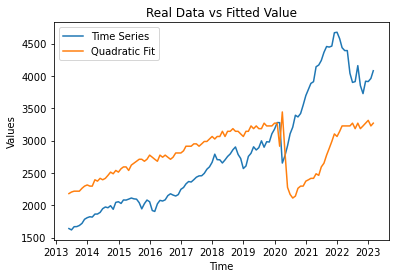

In [39]:
y_fit = qu_fit.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['SP500'], label='Time Series')
ax.plot(data.index, y_fit, label='Quadratic Fit')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Real Data vs Fitted Value')
plt.show()

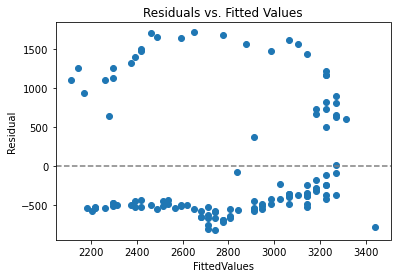

In [22]:
y_residual = qu_fit.resid

fig, ax = plt.subplots()
ax.scatter(y_fit, y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

<b>Comment: </b><br>  It seems like the risidual is evenly around zero. However, We can see a trend that increases and then decreases in the psitive side of the risidual，indicates that the model is not capturing all of the systematic variation in the data, and there may be some additional explanatory variables that should be included in the model.


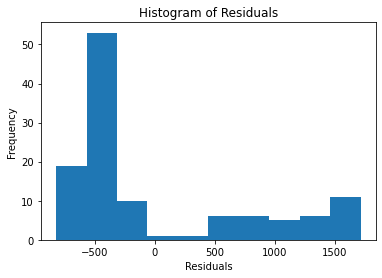

In [23]:
plt.hist(y_residual, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

<b>Comment: </b>The residual histogram shows that most residuals are smaller than zero. This means the fitted values are often smaller than actual values. There is also a decay in residuals' frequency. 

#### (3) Polynomial Model

In [44]:
po_fit = smf.ols('SP500 ~ UNRATE + I(UNRATE**2) + lag1_un', data = data).fit()
print(po_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  SP500   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.11
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           5.87e-06
Time:                        16:07:47   Log-Likelihood:                -951.20
No. Observations:                 118   AIC:                             1910.
Df Residuals:                     114   BIC:                             1921.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5878.2743    578.305     10.

<b>Comment: </b><br> 1. By adding a leading term the R-squared result(21%) suggests the model is a better fit than linear and similar to the quadratic model. <br>2. The p-value for F-statistic in this model is nearly 0, suggesting that this model is strongly statistically significant.<br> 3. P-value for the t-test of the model parameters shows that the model is statistically significant as well except for the quatratic term.

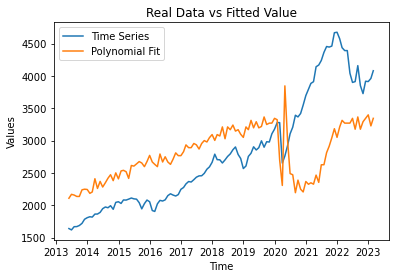

In [45]:
y_fit = po_fit.fittedvalues

fig, ax = plt.subplots()
ax.plot(data.index, data['SP500'], label='Time Series')
ax.plot(data.index, y_fit, label='Polynomial Fit')
ax.legend() 
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Real Data vs Fitted Value')
plt.show()

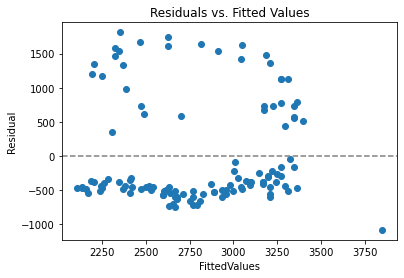

In [46]:
y_residual = po_fit.resid

fig, ax = plt.subplots()
ax.scatter(y_fit, y_residual)
ax.set_xlabel('FittedValues')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

<b>Comment: </b><br> Similar to the quadratic model, the residual plot indicates that the model is not capturing all of the systematic variation in the data, and there may be some additional explanatory variables that should be included in the model.

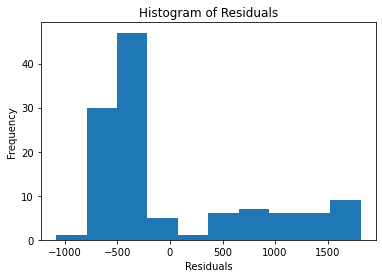

In [47]:
plt.hist(y_residual, bins=10)

# Add axis labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

<b>Comment: </b>The residual histogram shows that most residuals are smaller than zero. This means the fitted values are often smaller than actual values. There is also a decay in residuals' frequency.

### (e) AIC and BIC

In [48]:
li_aic = li_fit.aic
qu_aic = qu_fit.aic
po_aic = po_fit.aic

# compare the AIC values of the different models
print('Linear model AIC:', li_aic)
print('Quadratic model AIC:', qu_aic)
print('Polynomial model AIC:', po_aic)

Linear model AIC: 1926.3271261922498
Quadratic model AIC: 1914.2300387152407
Polynomial model AIC: 1910.407437947462


In [49]:
li_bic = li_fit.bic
qu_bic = qu_fit.bic
po_bic = po_fit.bic

# compare the BIC values of the different models
print('Linear model BIC:', li_bic)
print('Quadratic model BIC:', qu_bic)
print('Polynomial model BIC:', po_bic)

Linear model BIC: 1931.868495441181
Quadratic model BIC: 1922.5420925886376
Polynomial model BIC: 1921.4901764453248


<b> Comment: </b> <br> Both AIC and BIC indicates that the Polynomial model performs the best, so we will use it as our main model in the following analysis. 

### (f) 12 Steps Forecast

## 2. Trend and Seansonal Adjustments
### (a) Additive Decomposition 

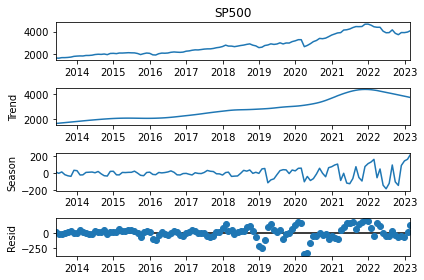

In [66]:
# Perform the additive decomposition
stl = STL(data['SP500']).fit()
fig = stl.plot()

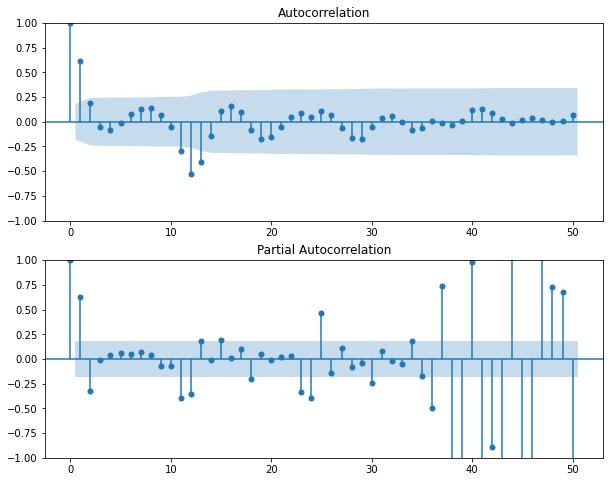

In [67]:
# Extract residuals from the fitted STL model
residuals = stl.resid

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=50, ax=axes[0])
plot_pacf(residuals, lags=50, ax=axes[1])
plt.show()

<b> Comments </b> <br> The PACF plot shows significant correlation at larger lags (e.g., 37-50) but not at smaller lags (e.g., 2-35), this suggests the presence of a long-term dependence or seasonality in the time series data. Specifically, it indicates that the current value of the time series is more strongly influenced by values that occurred many lags ago, rather than more recent values.

### (b) Multiplicative Decomposition

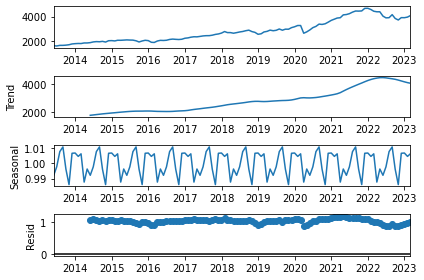

In [73]:
# Perform the multiplicative decomposition
mul_de = seasonal_decompose(data[['SP500']],model = "multiplicative",two_sided = False)
mul_de.plot();

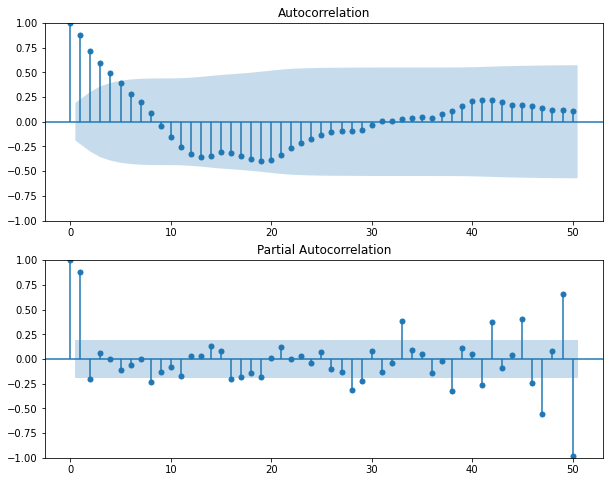

In [77]:
# Extract residuals from the fitted multiplicative decompose model
residuals = mul_de.resid.dropna()

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=50, ax=axes[0])
plot_pacf(residuals, lags=50, ax=axes[1])
plt.show()

<b> Comments </b> <br> This is similar to the additive model, the PACF plot shows significant correlation at larger lags (e.g., 46-50) but not at smaller lags (e.g., 3-30), this suggests the presence of a long-term dependence or seasonality in the time series data. Specifically, it indicates that the current value of the time series is more strongly influenced by values that occurred many lags ago, rather than more recent values. However, from the decomposition graph, we can tell that multiplicative method performs better since we have a smoother trend and a clearer seasonal factor right now.